# Hybrid QNN baseline
Descriptor-based hybrid classical-quantum regression baseline on a simulator.


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pennylane as qml
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

train = pd.read_csv("../data/train.csv")
val = pd.read_csv("../data/val.csv")
test = pd.read_csv("../data/test.csv")


In [8]:
DESC_FUNCS = [
    Descriptors.MolWt,
    Descriptors.MolLogP,
    Descriptors.TPSA,
    Descriptors.NumHDonors,
    Descriptors.NumHAcceptors,
    Descriptors.NumRotatableBonds,
    Descriptors.RingCount,
    Descriptors.FractionCSP3,
]  # 8 features = 8 qubits

def featurize(smiles):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return None
    v = [float(f(m)) for f in DESC_FUNCS]
    if any([np.isnan(x) or np.isinf(x) for x in v]):
        return None
    return v

def frame_to_Xy(df):
    feats, ys = [], []
    for s, y in zip(df.SMILES, df.Solubility):
        v = featurize(s)
        if v is not None:
            feats.append(v)
            ys.append(float(y))
    return np.array(feats, np.float32), np.array(ys, np.float32)

Xtr, ytr = frame_to_Xy(train)
Xva, yva = frame_to_Xy(val)
Xte, yte = frame_to_Xy(test)

sc = StandardScaler().fit(Xtr)
Xtr = sc.transform(Xtr)
Xva = sc.transform(Xva)
Xte = sc.transform(Xte)


[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not removing hydrogen atom without neighbors
[21:28:25] WARNING: not r

In [9]:
def train_epoch(model, X, y, opt, crit, bs=64):
    model.train()
    order = np.random.permutation(len(X))
    losses = []
    for i in range(0, len(X), bs):
        idx = order[i : i + bs]
        xb = torch.tensor(X[idx], dtype=torch.float32)
        yb = torch.tensor(y[idx], dtype=torch.float32)
        opt.zero_grad()
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def evaluate_q(model, X, y):
    xb = torch.tensor(X, dtype=torch.float32)
    pred = model(xb).float().detach().numpy()
    rmse = float(np.sqrt(((y - pred) ** 2).mean()))
    mae = float(np.mean(np.abs(y - pred)))
    r2 = float(r2_score(y, pred))
    return rmse, mae, r2, pred


## Hybrid classical-quantum model
Classical encoder -> strongly entangling quantum block -> linear head. Uses Pennylane's built-in entanglers to increase expressivity while TorchLayer reduces Python-side overhead. Fixed-epoch training keeps runtime predictable.

hybrid ep010 loss 2.7563 | val RMSE 1.844 R2 0.479
hybrid ep020 loss 2.5335 | val RMSE 1.699 R2 0.558
hybrid ep030 loss 2.3729 | val RMSE 1.709 R2 0.553
hybrid ep040 loss 2.3394 | val RMSE 1.657 R2 0.580
hybrid ep050 loss 2.2971 | val RMSE 1.642 R2 0.587
hybrid ep060 loss 2.2862 | val RMSE 1.657 R2 0.579
Hybrid test: 1.5034676790237427 1.1215274333953857 0.6720104217529297


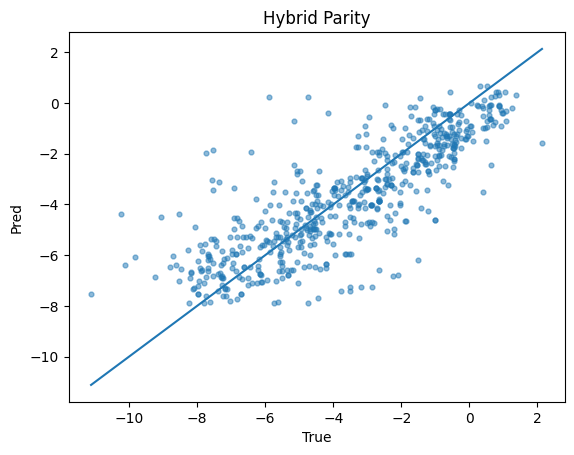

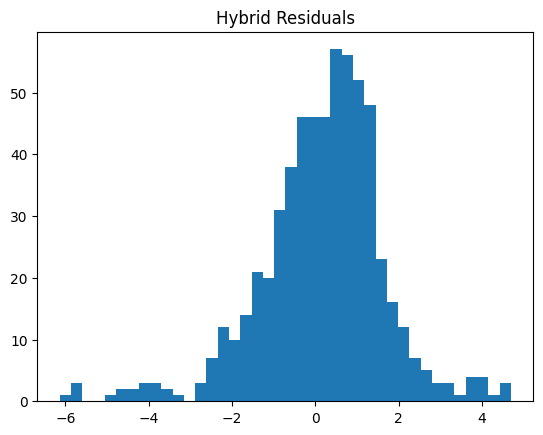

In [10]:
# Hybrid classical-quantum regression with richer entanglement
import math

NQ = Xtr.shape[1]
HYB_LAYERS = 3  # entanglement depth for the hybrid model
dev_h = qml.device("default.qubit", wires=NQ, shots=None)

def hybrid_circuit(inputs, weights):
    # Angle embedding followed by strongly entangling layers (ring/all-to-all pattern)
    qml.AngleEmbedding(inputs, wires=range(NQ), rotation="X")
    qml.StronglyEntanglingLayers(weights, wires=range(NQ))
    return [qml.expval(qml.PauliZ(i)) for i in range(NQ)]

weight_shapes = {"weights": (HYB_LAYERS, NQ, 3)}
hybrid_qnode = qml.QNode(hybrid_circuit, dev_h, interface="torch", diff_method="backprop")

class HybridReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(NQ, NQ),
            nn.ReLU(),
            nn.Linear(NQ, NQ),
        )
        self.q_layer = qml.qnn.TorchLayer(hybrid_qnode, weight_shapes)
        self.head = nn.Linear(NQ, 1)

    def forward(self, x):
        x = self.encoder(x)
        q_out = self.q_layer(x)
        return self.head(q_out).squeeze(-1)

# Training loop for fixed epochs
hybrid = HybridReg()
opt_h = torch.optim.Adam(hybrid.parameters(), lr=5e-3)
crit = nn.MSELoss()
best_rmse, best_state = 1e9, None
for ep in range(1, 61):  # cap epochs to avoid long runs
    tr_loss = train_epoch(hybrid, Xtr, ytr, opt_h, crit, bs=64)
    rmse, mae, r2, _ = evaluate_q(hybrid, Xva, yva)
    if rmse < best_rmse - 1e-4:
        best_rmse, best_state = rmse, {k: v.detach().clone() for k, v in hybrid.state_dict().items()}
    if ep % 10 == 0:
        print(f"hybrid ep{ep:03d} loss {tr_loss:.4f} | val RMSE {rmse:.3f} R2 {r2:.3f}")

if best_state is not None:
    hybrid.load_state_dict(best_state)

rmse, mae, r2, pred_te = evaluate_q(hybrid, Xte, yte)
print("Hybrid test:", rmse, mae, r2)
pd.DataFrame({"y_true": yte, "y_pred": pred_te}).to_csv("../results/hybrid_test_predictions.csv", index=False)

# Visuals for hybrid model
plt.figure()
plt.scatter(yte, pred_te, s=12, alpha=0.5)
lims = [min(yte.min(), pred_te.min()), max(yte.max(), pred_te.max())]
plt.plot(lims, lims)
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("Hybrid Parity")
plt.show()

plt.figure()
plt.hist(yte - pred_te, bins=40)
plt.title("Hybrid Residuals")
plt.show()


## Final metrics


In [11]:
# Final metrics on train/val/test splits
tr_rmse, tr_mae, tr_r2, _ = evaluate_q(hybrid, Xtr, ytr)
va_rmse, va_mae, va_r2, _ = evaluate_q(hybrid, Xva, yva)
te_rmse, te_mae, te_r2, _ = evaluate_q(hybrid, Xte, yte)

print("\nFinal metrics")
print(f"Train: RMSE {tr_rmse:.4f} | MAE {tr_mae:.4f} | R2 {tr_r2:.3f}")
print(f"Val:   RMSE {va_rmse:.4f} | MAE {va_mae:.4f} | R2 {va_r2:.3f}")
print(f"Test:  RMSE {te_rmse:.4f} | MAE {te_mae:.4f} | R2 {te_r2:.3f}")



Final metrics
Train: RMSE 1.5169 | MAE 1.0874 | R2 0.649
Val:   RMSE 1.6051 | MAE 1.1682 | R2 0.606
Test:  RMSE 1.5035 | MAE 1.1215 | R2 0.672


## Inference helpers
Convert SMILES to RDKit descriptors, scale with the fitted StandardScaler, and run the trained hybrid model for quick evaluations.


In [12]:
def prepare_for_prediction(compounds, scaler):
    names, smiles, feats = [], [], []
    for name, smi in compounds:
        v = featurize(smi)
        if v is None:
            continue
        names.append(name)
        smiles.append(smi)
        feats.append(v)

    if not feats:
        return names, smiles, torch.empty((0, len(DESC_FUNCS)), dtype=torch.float32)

    X = scaler.transform(np.array(feats, np.float32))
    return names, smiles, torch.tensor(X, dtype=torch.float32)


def predict_compounds(compounds, model, scaler):
    names, smiles, X = prepare_for_prediction(compounds, scaler)
    if len(names) == 0:
        return pd.DataFrame(columns=["Compound", "SMILES", "Predicted Solubility"])

    model.eval()
    with torch.no_grad():
        preds = model(X).cpu().numpy()

    return pd.DataFrame({
        "Compound": names,
        "SMILES": smiles,
        "Predicted Solubility": preds,
    })


## Example predictions


In [13]:
example_compounds = [
    ("Hexane", "CCCCCC"),
    ("Methanol", "CO"),
    ("Phenol", "c1cc(ccc1)O"),
    ("Decanol", "CCCCCCCCCCO"),
    ("Hydroquinone", "c1cc(ccc1O)O"),
]

example_df = predict_compounds(example_compounds, hybrid, sc)
print("Predicted solubilities (example compounds):")
display(example_df)


Predicted solubilities (example compounds):


,Compound,SMILES,Predicted Solubility
0,Hexane,CCCCCC,-2.581458
1,Methanol,CO,-0.455116
2,Phenol,c1cc(ccc1)O,-0.909700
3,Decanol,CCCCCCCCCCO,-2.706953
4,Hydroquinone,c1cc(ccc1O)O,-0.929751


## Stress-test predictions


In [14]:
stress_compounds = [
    ("Ethyl acetate", "CCOC(=O)C"),
    ("Butanol", "CCCCO"),
    ("Acetophenone", "CC(=O)c1ccccc1"),
    ("Glycerol", "C(C(CO)O)O"),
    ("Isobutanol", "CC(C)CO"),
]

stress_df = predict_compounds(stress_compounds, hybrid, sc)
print("Predicted solubilities (stress test molecules):")
display(stress_df)


Predicted solubilities (stress test molecules):


,Compound,SMILES,Predicted Solubility
0,Ethyl acetate,CCOC(=O)C,-0.928961
1,Butanol,CCCCO,-0.253631
2,Acetophenone,CC(=O)c1ccccc1,-2.422377
3,Glycerol,C(C(CO)O)O,0.276635
4,Isobutanol,CC(C)CO,-0.410480


## Aromatic group predictions


Predicted solubilities (aromatic test compounds, grouped):


,Compound,SMILES,Predicted Solubility
0,Phenol,c1ccccc1O,-0.909700
1,Hydroquinone,c1cc(ccc1O)O,-0.929751
2,Aniline,c1ccccc1N,-0.834362
3,Nitrobenzene,c1ccccc1[N+](=O)[O-],-1.772088
4,Benzaldehyde,O=CC1=CC=CC=C1,-1.875620
5,Benzene,c1ccccc1,-1.878251
6,Toluene,Cc1ccccc1,-2.433526
7,Chlorobenzene,c1ccccc1Cl,-2.571280
8,Bromobenzene,c1ccccc1Br,-3.134141
9,Acetophenone,CC(=O)c1ccccc1,-2.422377


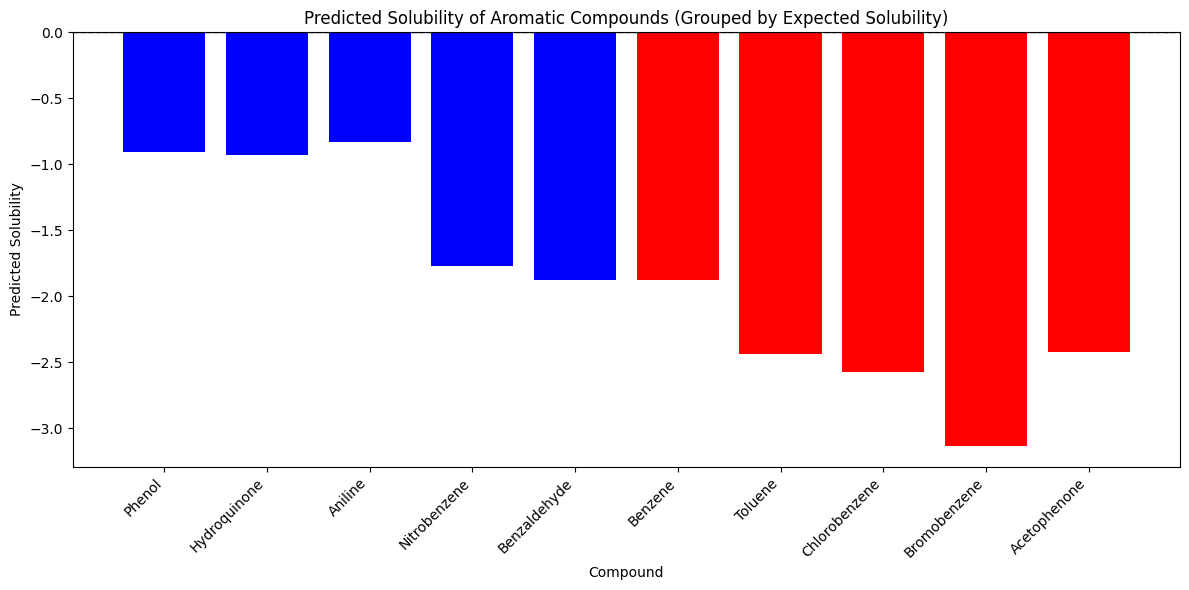

In [15]:
soluble_compounds = [
    ("Phenol", "c1ccccc1O"),
    ("Hydroquinone", "c1cc(ccc1O)O"),
    ("Aniline", "c1ccccc1N"),
    ("Nitrobenzene", "c1ccccc1[N+](=O)[O-]"),
    ("Benzaldehyde", "O=CC1=CC=CC=C1"),
]

insoluble_compounds = [
    ("Benzene", "c1ccccc1"),
    ("Toluene", "Cc1ccccc1"),
    ("Chlorobenzene", "c1ccccc1Cl"),
    ("Bromobenzene", "c1ccccc1Br"),
    ("Acetophenone", "CC(=O)c1ccccc1"),
]

aromatic_df = predict_compounds(soluble_compounds + insoluble_compounds, hybrid, sc)
print("Predicted solubilities (aromatic test compounds, grouped):")
display(aromatic_df)

if not aromatic_df.empty:
    plt.figure(figsize=(12, 6))
    colors = ['blue'] * len(soluble_compounds) + ['red'] * len(insoluble_compounds)
    plt.bar(aromatic_df['Compound'], aromatic_df['Predicted Solubility'], color=colors)
    plt.xlabel("Compound")
    plt.ylabel("Predicted Solubility")
    plt.title("Predicted Solubility of Aromatic Compounds (Grouped by Expected Solubility)")
    plt.xticks(rotation=45, ha='right')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()
else:
    print("No valid aromatic compounds to plot.")
